<a href="https://colab.research.google.com/github/abhishekv23/eMastersAI/blob/main/sparse_reward_learning_with_HER_Distance%2BSpeed_Goal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. import libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Enable logging

In [4]:
import logging
import sys
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
# Configure logging
logging.basicConfig(
    level=logging.INFO,  # default level
    format="[%(funcName)s] %(message)s",
    handlers=[logging.StreamHandler(sys.stdout),              # log to console
        logging.FileHandler("training.log", mode="w"),  # log to file
    ])

logger = logging.getLogger(__name__)


## 2. Setup the environment

In [39]:
# Traffic Signal Simulation Environment with Gym
class TrafficSignalSimEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.signal_position = 470.0
        self.speed_limit = 15.0
        self.w_jerk = 2
        self.w_acc = 0.2
        self.TLcolor = 0
        #Defin ethe observation space for state and action (mandatory for gym subclass)
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, 0]),
            high=np.array([470.0, 15.0, 2]),
            dtype=np.float32
        )
        # define the action space (mandatory)
        self.action_space = gym.spaces.Box(
            low=np.array([-3.0]),
            high=np.array([3.0]),
            dtype=np.float32
        )
        # time step
        self.dt = 0.04
        # maximum simulation time
        #self.max_time = 60
        # reset the environment
        #self.reset()

    #Calculate the signal state from known signal transition timing
    def get_signal_state(self, time):
        cycle = 90
        phase_time = [16, 21, 46] # updated sinal interval
        #phase_time = [87, 90, 90]
        #phase_time = [90, 0, 0] # all green

        if phase_time[0] <= (time+cycle) % cycle < phase_time[1]:
            self.TLcolor = 1 #"yellow"
            #g = time
            #r = time + (phase_time[1] - (time+cycle) % cycle)
            #g_next = time + (phase_time[2] - (time+cycle) % cycle)
        elif phase_time[1] <= (time+cycle) % cycle < phase_time[2]:
            self.TLcolor = 0 #"red"
            #g = time + (phase_time[2] - (time+cycle) % cycle)
            #r = time - ((time+cycle) % cycle-phase_time[1])+cycle
            #g_next = time + (phase_time[2] - (time+cycle) % cycle) + cycle
        else:
            self.TLcolor = 2 #"green"
            #g = time
            #if (time+cycle) % cycle<phase_time[0]:
                #r=time + (phase_time[1] - (time+cycle) % cycle)
                #g_next = time - (time+cycle) % cycle + cycle
            #else:
                #r = time - ((time+cycle) % cycle-phase_time[1])+cycle
                #g_next = time - ((time+cycle) % cycle - phase_time[2]) + cycle

        #return TLcolor, [g,r,g_next,g_next+cycle-phase_time[2]+phase_time[0]]
        return self.TLcolor

    #Define the reward function that can be called from both step() and HER relabel
    def compute_reward(self, state, action, reward, next_state, done, g_prime, achieved_goal):
        #achieved_goal is derived from the next_state while g_prime is the new goal same as the achieved goal from future state.
        #we need to re-compute the reward based on this new goal(g_prime)
        new_d_tl = achieved_goal[0]
        new_speed = achieved_goal[1]
        TLcolor = next_state[2]
        #Traffic signal reward
        signal_position = self.signal_position
        #crossed_signal = (dist < signal_position) and (new_dist >= signal_position)
        #near_signal = abs(dist - signal_position) < 5.0
        speed_threshold = 0.1  # Below this: considered stopped

        reward_green = 0.1
        penalty_red = -2.0
        penalty_stall = -1.0
        reward_stop_on_red = 5.0
        overspeed_penalty = -1.0

        fTL = 0.0
        achieved_goal[1]# speed of agent

        g_prime[0]#distance of new goal state from signal
        g_prime[1]#speed of new goal state , this could give us wrong signal as well. so dont trust it.
        g_prime[2]#signal state of future state

        #if achieved state and goal state are same them penalize and return
        if g_prime[0] > 2.0 and g_prime[1] < speed_threshold:
          return reward - 5.0 #large penalty

        #if signal state at g_prime is green, then agent should maintain good speed, give +ve reward if speed is maintained
        if g_prime[2] == 2: #try to regulate the speed
          if 10.0 < achieved_goal[1] < 15.0:
            fTL = reward_green
            logger.debug("Reward for maintaining speed in green: %s", fTL)
          elif 5.0 < achieved_goal[1] <= 10.0:
            fTL = reward_green/5
            logger.debug("Reward for maintaining speed in green: %s", fTL)
          elif 1.0 < achieved_goal[1] <= 5.0:
            fTL = reward_green/10
            logger.debug("Reward for maintaining speed in green: %s", fTL)
          elif achieved_goal[1] <= 1: #speed is tool low without reason, penalize
            fTL = penalty_stall
            logger.debug("Reward for stalling", fTL)

        #if signal state at g_prime is Yellow or Red, then agent should check for distance
        if g_prime[2] in (1, 0):
          #agent is at less distance than stopping distance
          if 10.0 < achieved_goal[1] < 15.0:
            fTL = overspeed_penalty
            logger.debug("Reward for maintaining speed in green", fTL)
          elif 5.0 < achieved_goal[1] <= 10.0:
            fTL = overspeed_penalty/5
            logger.debug("Reward for maintaining speed in green: %s", fTL)
          elif achieved_goal[1] <= 5.0:
            fTL = overspeed_penalty/10
            logger.debug("Reward for maintaining speed in green: %s", fTL)
          elif achieved_goal[1] <= 1: #speed is tool low without reason, penalize
            fTL = reward_stop_on_red/abs(achieved_goal[0]-g_prime(0))
            logger.debug("Reward for stopping on red", fTL)


        #self.penalty_vlimit_weight = 1.0
        if new_speed > self.speed_limit:
            fvlimit = overspeed_penalty #-self.penalty_vlimit_weight * ((new_speed - self.speed_limit) / self.speed_limit) ** 2
            logger.debug("Penalty for crossing the speed limit: %s", fvlimit)
        else:
            fvlimit = 0
        # Total reward, combining all factors
        r_prime =  fTL + fvlimit #not using acceleration penalty
        #return reward + r_prime
        return reward+ r_prime

    #define the reset method
    def reset(self, row_data):

        #dist_to_signal = row_data['fv_positions']    # or some derived dist if needed
        #speed = row_data['FVSpd']
        #start_time = row_data['time']

        # Reset simulation time
        self.time = row_data['time']

        # Reset last action (for jerk calculation)
        self.last_action = 0.0

        # Set simulation step duration (seconds)
        self.dt = .04

        # Define speed limit
        self.speed_limit = 54 / 3.6  # 54 km/h in m/s

        # Define max episode time
        #self.max_time = 60.0  # seconds

        # Distance
        d_tl = self.signal_position - row_data['FV_positions']


        # Starting speed (m/s)
        speed = row_data['FVSpd']
        # Initial signal state
        TLcolor = self.get_signal_state(self.time)
        #signal_state = {"red": 0, "yellow": 1, "green": 2}[TLcolor]
        signal_state = TLcolor
        # Create initial state vector
        self.state = np.array([d_tl, speed, signal_state], dtype=np.float32)

        #achieved goal is same as the distance to the signal
        achieved_goal = np.array([d_tl, speed, TLcolor], dtype=np.float32)
        #desired goal is to reach the signal
        desired_goal = np.array([0.0, 10.0, 0], dtype=np.float32) #final distance should be zero and speed should be 10m/s

        return {
            "state":self.state,
                "achieved_goal": achieved_goal,
                "desired_goal": desired_goal,
                }

    # define the step method
    def step(self, action):

        # Unpack current state
        d_tl, speed, _ = self.state
        dist = self.signal_position - d_tl  # Calculate distance from stop line
        #print(dist_to_signal)

        # Update time by a timestep
        self.time += self.dt
        # calculate jerk as the rate of change of acceleration
        jerk = (action - self.last_action) / self.dt
        # new speed can't be negative
        new_speed = max(0.0, speed + action * self.dt)
        # calculate new distance based on speed and acceleration
        new_dist = dist + speed * self.dt + 0.5 * action * (self.dt ** 2)
        new_dist = max(dist, new_dist)  # Ensure distance is not decreasing
        #print(self.dt)
        self.last_action = action

        # Traffic light state
        TLcolor = self.get_signal_state(self.time)
        signal_state = TLcolor
        # Calculate distance to stop line
        new_d_tl = 470 - new_dist

        # Reward
        stop_reward = 0
        violation_penalty = 0
        fTL = 0

        #Traffic signal reward
        signal_position = 470.0
        crossed_signal = (dist < signal_position) and (new_dist >= signal_position)
        near_signal = abs(dist - signal_position) < 5.0
        speed_threshold = 0.1  # Below this: considered stopped

        reward_green = 0.5
        penalty_red = -5.0
        penalty_stall = -1.0
        reward_stop_on_red = 5.0

        fTL = 0.0
        done = False

        if new_d_tl>2.0 and speed < speed_threshold:
          fTL = -5.0 #large penalty
        # Case 1: Crossed the signal
        elif crossed_signal:
            if TLcolor in (1, 2):  # green or yellow
                fTL = reward_green
                logger.debug("Reward for crossing the signal in Green and Yellow: %s", fTL)
            else:  # red
                fTL = penalty_red
                logger.debug("Penalty for crossing the signal in Red: %s", fTL)

        # Case 2: Stalled at green/yellow (should have crossed)
        elif TLcolor == 2 and speed < speed_threshold:
            fTL = penalty_stall
            logger.debug("Penalty for stalling: %s", fTL)

        # Case 3: Stopped correctly at red light
        elif near_signal and TLcolor == 0 and speed < speed_threshold and not crossed_signal:
            fTL = reward_stop_on_red
            logger.debug("Reward for stopping on Red: %s", fTL)

        # Jerk penalty, for comfortable drive
        fJerk = -self.w_jerk * (jerk ** 2) / ((4 + 2) / 0.04) ** 2
        #logger.debug(f"Jerk penalty: %s: {fJerk:.2f}")

        # Acceleration penalty, for fuel efficient driving
        if action <= 0:
            fAcc = -self.w_acc * (abs(action) / 4) ** 0.5
        else:
            fAcc = -self.w_acc * (abs(action) / 2) ** 0.5

        # Speed limit penalty
        self.penalty_vlimit_weight = 1.0
        if new_speed > self.speed_limit:
            fvlimit = -1.0#-self.penalty_vlimit_weight * ((new_speed - self.speed_limit) / self.speed_limit) ** 2
            logger.debug("Penalty for crossing the speed limit: %s", fvlimit)
        else:
            fvlimit = 0
        # Total reward, combining all factors
        reward =  fTL +fvlimit #not using acceleration penalty

        # Terminal condition
        #done = (new_dist < 0 or self.time >= self.max_time)
        done = new_dist >= 470
        # Update state
        self.state = np.array([new_d_tl, new_speed, signal_state], dtype=np.float32)

        #achieved goal is same as the next state
        achieved_goal = np.array([new_d_tl, new_speed, signal_state], dtype=np.float32)
        #desired goal is to reach the signal
        desired_goal = np.array([0.0, 10.0, 0], dtype=np.float32) #final distance should be zero and speed should be 10m/s

        info = {
        "TLcolor": self.TLcolor
        }

        #reward = self.compute_reward(achieved_goal, desired_goal, self.state, action, next_state, info)

        return {
            "state":self.state,
            "achieved_goal":achieved_goal,
            "desired_goal": desired_goal,
            }, reward, done, {}

    #HER relabelling function
    def her_relabel(self, episode, k=4):
      # empty list to hold HER modified transitions
      new_transitions = []
      #iterate over the transitions, corresponding to each transition, sample 4 future transitions and create 4 HER updated transitions.
      #Add updated transitions to HER Buffer
      for i, (state, action, reward, next_state, done, goal, achieved_goal) in enumerate(episode):
          logger.debug(f"Original transition: State={state}, Action={action}, Reward={reward}, "
                 f"Next State={next_state}, Done={done}, Goal={goal}, Achieved={achieved_goal}")
          #filter out invalid future transitions
          #compliant_episode = [compliant_transition for compliant_transition in episode if is_compliant(compliant_transition)]
          available = len(episode) - i
          if available <= 1:
              continue
          k_eff = min(k, available)  # avoid oversampling
          #sample k future transitions
          future_indices = np.random.choice(range(i,len(episode)), k_eff, replace=False)
          logger.debug(f"sampled future indices: {future_indices}")

          #iterate over those sampled indices to update
          for index in future_indices:
              #print("index: ", index)
              # pick a future achieved goal as the new desired goal for the updated transition, if it is compliant
              if env.is_compliant(episode[index][6]):
                g_prime = episode[index][6]  # episode[index][6] = achieved_goal
              else:
                logger.info(f"Invalid future state, skipping:{episode[index][6]}")
                continue
              #
              #g_prime = episode[index][6]  # episode[index][6] = achieved_goal
              # compute the new reward, if the next state is close to the new goal
              #info = {"TLcolor": self.TLcolor}
              r_prime = 0 #dont use the old reward for recomputing her reward.
              #I would like to use below method to compute the reward later on.
              r_prime = self.compute_reward(state, action, reward, next_state, done, g_prime, achieved_goal)
              """if (achieved_goal -  goal) < 15.0 and next_state[1] != 0.0:
                r_prime += 0.5
                logger.debug("recomputed reward is ",r_prime)
              """
              #add the modified transition to the list
              new_transitions.append((state, action, r_prime, next_state, done, g_prime, achieved_goal))

              logger.debug(f"HER Updated: State={state}, Action={action}, Reward={r_prime}, "
                    f"Next State={next_state}, Done={done}, Goal={g_prime}, "
                    f"Achieved={achieved_goal}")

      logger.debug(f"Number of HER transitions: {len(new_transitions)}")
      return new_transitions

    #check if sampled future state is TL compliant
    def is_compliant(self, future_state):
      d_tl, speed, signal = future_state

      stopline_thresh = 2.0
      min_stop_speed = 0.2
      min_go_speed = 0.5

      # Far zone → always valid
      if d_tl > stopline_thresh:
          return True

      if signal == 0:  # RED
          return speed <= min_stop_speed

      elif signal == 2:  # GREEN
          return speed >= min_go_speed or d_tl <= 0

      elif signal == 1:  # YELLOW
          # Allow all cases
          return True

      return False


## 3. Define function for loading data and processing

In [7]:
import pandas as pd
#csv_path = "/content/drive/MyDrive/real_sim_trainSet_0_280_475.csv"
# Load vehicle sequences from CSV file
def load_training_data(csv_path):

    df = pd.read_csv(csv_path)

    required_cols = ['FV_veh_id', 'FV_positions', 'FVSpd', 'time']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    # Sort by time and pick the first row per vehicle
    first_entries = (
        df.sort_values('time')
          .groupby('FV_veh_id', as_index=False)
          .first()
    )

    return first_entries[['FV_veh_id', 'FV_positions', 'FVSpd', 'time']]


[_init_num_threads] NumExpr defaulting to 2 threads.


## 4. Load training data

In [8]:
env = TrafficSignalSimEnv()
csv_path = "/content/drive/MyDrive/real_sim_trainSet_0_280_475.csv"
#load the data and then reset the env with the loaded data for each episode
episode_starting_data = load_training_data(csv_path)


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## 5. Define Actor & Critic network

In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, state_dim, goal_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim+goal_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)

        self.max_action = max_action
        # Initialize final layer like DDPG
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.bias.data.uniform_(-3e-3, 3e-3)
        # Normalization constants
        self.norm_constants = torch.tensor([150.0, 15.0, 2.0, 150.0, 15.0, 2])

    def forward(self, state, goal):
        x = torch.cat([state, goal], dim=-1)
        # Normalize input (element-wise division)
        x = x / self.norm_constants.to(x.device)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        #print("x:", x)
        #print("max action:", self.max_action)
        return self.max_action*x


class Critic(nn.Module):
    def __init__(self, state_dim, goal_dim, action_dim, max_action):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + goal_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.max_action = max_action
        # Normalization constants
        self.norm_constants = torch.tensor([150.0, 15.0, 2.0, 150.0, 15.0, 2, 3])

    def forward(self, state, goal, action):
        # Normalize state

        #action = (action + self.max_action) / (2 * self.max_action) # Normalize to [0, 1]
        x = torch.cat([state, goal, action], dim=-1)
        x = x / self.norm_constants.to(state.device)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

## Initialize the Actor and Critic networks

In [40]:
#initialize the environment
env = TrafficSignalSimEnv()
state_dim = env.observation_space.shape[0]
goal_dim = 3 #desired goal
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]
#initialize actor network
actor = Actor(state_dim, goal_dim, action_dim, max_action)
#initialize critic network
critic = Critic(state_dim, goal_dim, action_dim, max_action)
#initialize target actor network
target_actor = Actor(state_dim, goal_dim, action_dim, max_action)
#initialize target critic network
target_critic = Critic(state_dim, goal_dim, action_dim, max_action)

#initialize optimizers for actor and critic networks
actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic.parameters(), lr=1e-4)

exploration_noise = 0.5
max_transition_per_episode = 500

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Generate the episode transitions

In [11]:

for episode, row in episode_starting_data.iterrows():
  obs = env.reset(row)
  state, achieved_goal, goal = obs["state"], obs["achieved_goal"], obs["desired_goal"]
  logger.info(f"\n--- Episode {episode+1} start ---")
  episode_transitions = []
  episode_reward = 0
  #initialize with False and it will be set appropriately in step function
  done = False
  step = 0
  logger.debug(f"Step {step}: State[dist, speed, signal_state], Action, Reward, Next State[dist, speed, signal_state], Done")
  while not done and step < max_transition_per_episode:
      state_tensor = torch.FloatTensor(state).unsqueeze(0) # convert state to tensor
      goal_tensor = torch.FloatTensor(goal).unsqueeze(0) # convert goal to tensor
      action = actor(state_tensor, goal_tensor).detach().numpy()[0] # action sampling from actor network
      logger.debug("raw action:: %s", action)
      action += np.random.normal(0, exploration_noise, size=action_dim) # add exploration noise
      logger.debug("exploration noise added:: %s", action)
      action = np.clip(action, min_action, max_action)[0] # action clipping for safety
      logger.debug("clipped action:: %s", action)
      # take a step in the environment
      next_obs, reward, done, _ = env.step(action)
      #extract next state and goal
      next_state, next_achieved_goal, goal = next_obs["state"], next_obs["achieved_goal"], next_obs["desired_goal"]
      logger.debug(f"Step {step}: State={state}, Action={action}, Reward={reward}, Next State={next_state}, Done={done}, Goal={goal}, Achieved_goal={next_achieved_goal}")
      episode_transitions.append((state, action, reward, next_state, done, goal, next_achieved_goal))
      #replay_buffer.add((state, action, reward, next_state, done, goal))

      episode_reward += reward
      state = next_state
      step += 1
  #Break the for loop after printing 1 episode transitions
  break

[<cell line: 0>] 
--- Episode 1 start ---


## 6. Replay buffer

In [12]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)
    def add(self, transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))
#initialize replay buffer
replay_buffer = ReplayBuffer()

## 7. Function to relabel transitions for HER (this function is moved to env class)

In [ ]:
"""def her_relabel(env, episode, k=4):
    # empty list to hold HER modified transitions
    new_transitions = []
    #iterate over the transitions, corresponding to each transition, sample 4 future transitions and create 4 HER updated transitions.
    #Add updated transitions to HER Buffer
    for i, (state, action, reward, next_state, done, goal, achieved_goal) in enumerate(episode):
        #print(f"Original transition: State={state}, Action={action}, Reward={reward}, "
              #f"Next State={next_state}, Done={done}, Goal={goal}, Achieved={achieved_goal}")
        available = len(episode) - i
        if available <= 1:
            continue
        k_eff = min(k, available)  # avoid oversampling
        #sample k future transitions
        future_indices = np.random.choice(range(i,len(episode)), k_eff, replace=False)
        #print(f"sampled future indices: {future_indices}")

        #iterate over those sampled indices to update
        for index in future_indices:
            #print("index: ", index)
            # pick a future achieved goal as the new desired goal
            g_prime = episode[index][6]  # episode[index][6] = achieved_goal
            # compute the new reward, if the next state is close to the new goal
            info = {"TLcolor": env.TLcolor}

            r_prime = env.compute_reward(
                state, action, reward, next_state, done, g_prime, achieved_goal
            )

            #add the modified transition to the list
            new_transitions.append((state, action, r_prime, next_state, done, g_prime, achieved_goal))
            #print(f"HER Updated: State={state}, Action={action}, Reward={r_prime}, "
                  #f"Next State={next_state}, Done={done}, Goal={g_prime}, "
                  #f"Achieved={achieved_goal}")

    print(f"Number of HER transitions: {len(new_transitions)}")
    return new_transitions"""

'def her_relabel(env, episode, k=4):\n    # empty list to hold HER modified transitions\n    new_transitions = []\n    #iterate over the transitions, corresponding to each transition, sample 4 future transitions and create 4 HER updated transitions.\n    #Add updated transitions to HER Buffer\n    for i, (state, action, reward, next_state, done, goal, achieved_goal) in enumerate(episode):\n        #print(f"Original transition: State={state}, Action={action}, Reward={reward}, "\n              #f"Next State={next_state}, Done={done}, Goal={goal}, Achieved={achieved_goal}")\n        available = len(episode) - i\n        if available <= 1:\n            continue\n        k_eff = min(k, available)  # avoid oversampling\n        #sample k future transitions\n        future_indices = np.random.choice(range(i,len(episode)), k_eff, replace=False)\n        #print(f"sampled future indices: {future_indices}")\n\n        #iterate over those sampled indices to update\n        for index in future_indi

## HER relabelling

In [ ]:
#print(f"Replay buffer size: {len(replay_buffer.buffer)}")
#HER relabeling
logger.debug(f"Relabeling transitions for episode {episode+1}")
her_transitions = env.her_relabel(episode_transitions)
#look at the her transitions

In [ ]:
#print replay buffer contents
index =1
for transition in replay_buffer.buffer:
  index +=1
  #print the transitions as states, actions, rewards, next_states, dones, goals, achieved_goals
  #get the index of the transition
  if index > 1000:
    break
  states, actions, rewards, next_states, dones, goals, achieved_goals = transition
  logger.info(f"State={states}, Action={actions}, Reward={rewards}, Next State={next_states}, Done={dones}, Goal={goals}, Achieved={achieved_goals}")


2025-08-28 05:20:11,096 [INFO] [<cell line: 0>] State=[118.84326   0.        2.     ], Action=-3.0, Reward=-1.0, Next State=[118.84326   0.        2.     ], Done=False, Goal=[118.84326   0.        2.     ], Achieved=[118.84326   0.        2.     ]
2025-08-28 05:20:11,098 [INFO] [<cell line: 0>] State=[118.84326   0.        2.     ], Action=-3.0, Reward=-1.0, Next State=[118.84326   0.        2.     ], Done=False, Goal=[118.84326   0.        2.     ], Achieved=[118.84326   0.        2.     ]
2025-08-28 05:20:11,100 [INFO] [<cell line: 0>] State=[118.84326   0.        2.     ], Action=-3.0, Reward=-1.0, Next State=[118.84326   0.        2.     ], Done=False, Goal=[118.84326   0.        2.     ], Achieved=[118.84326   0.        2.     ]
2025-08-28 05:20:11,101 [INFO] [<cell line: 0>] State=[118.84326   0.        2.     ], Action=-3.0, Reward=-1.0, Next State=[118.84326   0.        2.     ], Done=False, Goal=[118.84326   0.        2.     ], Achieved=[118.84326   0.        2.     ]
2025-08-

## 9. Training data starting iterations

In [ ]:
#print the entries of episode starting data
for idx, row in episode_starting_data.iterrows():
    logger.debug(row)
    logger.debug(f"Episode {idx+1}: {row.to_dict()}")

## 10. Training parameters

In [41]:
gamma =0.99
tau = 0.005 # for soft target updates
batch_size = 32
episode_rewards = []
avg_critic_losses = []
avg_actor_losses = []
#initialize replay buffer
replay_buffer = ReplayBuffer()

## 11. Training loop

In [42]:
#Training loop
epochs = 1
# Track the best actor loss seen so far
best_actor_loss = float('inf')
#go over this training data set for number of epochs
for epoch in range(epochs):
    for episode, row in episode_starting_data.iterrows():
        obs = env.reset(row)
        state, achieved_goal, goal = obs["state"], obs["achieved_goal"], obs["desired_goal"]
        logger.debug(f"\n--- Episode {episode+1} start ---")
        #goal = state[:1] # distance from start as the goal reference
        episode_transitions = []
        episode_reward = 0
        #initialize with False and it will be set appropriately in step function
        done = False
        step = 0
        max_steps = 1000
        while not done and step < max_steps:
            state_tensor = torch.FloatTensor(state).unsqueeze(0) # convert state to tensor
            goal_tensor = torch.FloatTensor(goal).unsqueeze(0) # convert goal to tensor
            action = actor(state_tensor, goal_tensor).detach().numpy()[0] # action sampling from actor network
            logger.debug("raw action:: %s", action)
            action += np.random.normal(0, exploration_noise, size=action_dim) # add exploration noise
            logger.debug("exploration noise added:: %s", action)
            action = np.clip(action, min_action, max_action)[0] # action clipping for safety
            logger.debug("clipped action:: %s", action)
            # take a step in the environment
            next_obs, reward, done, _ = env.step(action)
            next_state, next_achieved_goal, next_goal = (
                next_obs["state"], next_obs["achieved_goal"], next_obs["desired_goal"]
            )
            # Save transition
            episode_transitions.append((state, action, reward, next_state, done, goal, next_achieved_goal))
            #replay_buffer.add((state, action, reward, next_state, done, goal, achieved_goal))
            logger.debug(f"Step {step}: State={state}, Action={action}, Reward={reward}, Next State={next_state}, Done={done}, Goal={goal}, Achieved_goal={next_achieved_goal}")

            episode_reward += reward
            state, achieved_goal, goal = next_state, next_achieved_goal, next_goal
            step += 1
        #print the status of replay buffer
        logger.debug(f"Replay buffer size: {len(replay_buffer.buffer)}")

        #HER relabeling
        logger.debug(f"Relabeling transitions for episode {episode+1}")
        her_transitions = env.her_relabel(episode_transitions)
        for transition in her_transitions:
            replay_buffer.add(transition)

        critic_losses = []
        actor_losses = []
        # Sample a batch from the replay buffer
        logger.debug(f"Sampling batch of size {batch_size} from replay buffer")
        if len(replay_buffer.buffer) >= batch_size:
            for i in range(50):  # Update for 50 iterations per episode
                #print(f"Updating networks for episode {episode+1}, iteration {i+1}")
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones, goals, achieved_goals = zip(*batch)


                # Convert to tensors
                states = torch.FloatTensor(np.array(states))
                actions = torch.FloatTensor(np.array(actions)).unsqueeze(1)
                rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1)
                next_states = torch.FloatTensor(np.array(next_states))
                goals = torch.FloatTensor(np.array(goals))
                #dones = torch.FloatTensor(np.array(dones)).unsqueeze(1)

                with torch.no_grad():
                    #Critic update
                    target_actions = target_actor(next_states, goals)

                    target_q = target_critic(next_states, goals, target_actions)
                    target_q = rewards + gamma * target_q

                logger.debug("states shape:", states.shape)
                logger.debug("actions shape:: %s", actions.shape)
                #current_q = critic(states, actions.unsqueeze(1))
                current_q = critic(states, goals, actions)
                critic_loss = nn.MSELoss()(current_q, target_q.detach())
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                #Actor update
                actor_loss = -critic(states, goals, actor(states, goals)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Soft update of target networks
                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                #accumulate actor and critic losses for whole episode
                critic_losses.append(critic_loss.item())
                actor_losses.append(actor_loss.item())

        logger.info(f"Episode {episode+1} ended. Total Reward: {episode_reward}")
        #save the episode reward
        episode_rewards.append(episode_reward)
        #calculate average episode loss and save it
        avg_critic_losses.append(np.mean(critic_losses))
        avg_actor_losses.append(np.mean(actor_losses))
        logger.info(f"Average Critic Loss: {np.mean(critic_losses)}, Average Actor Loss: {np.mean(actor_losses)}")
        #after each episode of training, check the loss
        #if loss is decreasing, then save the model with best loss
        # Save model if actor loss improved
        current_actor_loss = np.mean(actor_losses)

        if current_actor_loss < best_actor_loss:
          logger.info(f"Actor loss improved to {current_actor_loss:.4f}. Saving model.")
          best_actor_loss = current_actor_loss
          torch.save(actor.state_dict(), "/content/drive/MyDrive/sparse_reward_learning_with_HER_Distance+Speed+Signal_Goal.pth")
        #just execute for 1 episode of transitions
        #break

env.close()

[<cell line: 0>] Episode 1 ended. Total Reward: 0.5
[<cell line: 0>] Average Critic Loss: 0.07842441465705634, Average Actor Loss: -0.06293117269873619
[<cell line: 0>] Actor loss improved to -0.0629. Saving model.
[<cell line: 0>] Episode 2 ended. Total Reward: 0.5
[<cell line: 0>] Average Critic Loss: 0.018522632024250925, Average Actor Loss: 0.021618106260430068
[her_relabel] Invalid future state, skipping:[1.7993164 7.4299445 0.       ]
[her_relabel] Invalid future state, skipping:[0.90789795 7.4353743  0.        ]
[her_relabel] Invalid future state, skipping:[0.31280518 7.457571   0.        ]
[her_relabel] Invalid future state, skipping:[1.5021973 7.426078  0.       ]
[her_relabel] Invalid future state, skipping:[1.2051392 7.426454  0.       ]
[her_relabel] Invalid future state, skipping:[0.01425171 7.4697914  0.        ]
[her_relabel] Invalid future state, skipping:[-0.28424072  7.453908    0.        ]
[her_relabel] Invalid future state, skipping:[1.7993164 7.4299445 0.       ]
[

## 12. Visualizing training progress

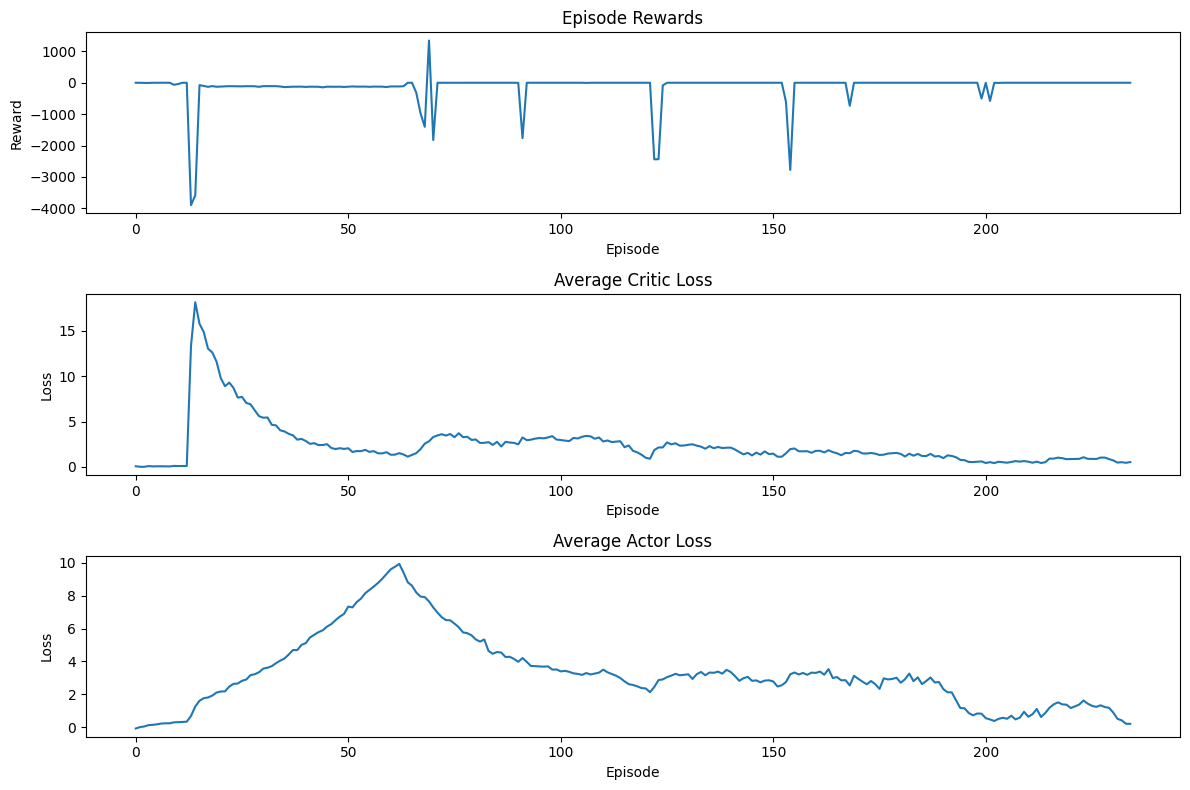

In [43]:

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(3, 1, 2)
plt.plot(avg_critic_losses)
plt.title("Average Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(3, 1, 3)
plt.plot(avg_actor_losses)
plt.title("Average Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

# Prepare for agent testing

## Load the saved Actor agent network

In [ ]:
# Load the model
actor.load_state_dict(torch.load("/content/drive/MyDrive/actor_best.pth"))
#critic.load_state_dict(torch.load("critic.pth"))
# Set the models to evaluation mode
actor.eval()
#critic.eval()

Actor(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

## Load the test data and observe agent performance on Test dataset

/tmp/ipython-input-3166947082.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_episode_starting_data = pd.concat([test_episode_starting_data, new_row], ignore_index=True)



--- Episode 1 start ---
[<cell line: 0>] Episode 1 ended. Total Reward: -5.0


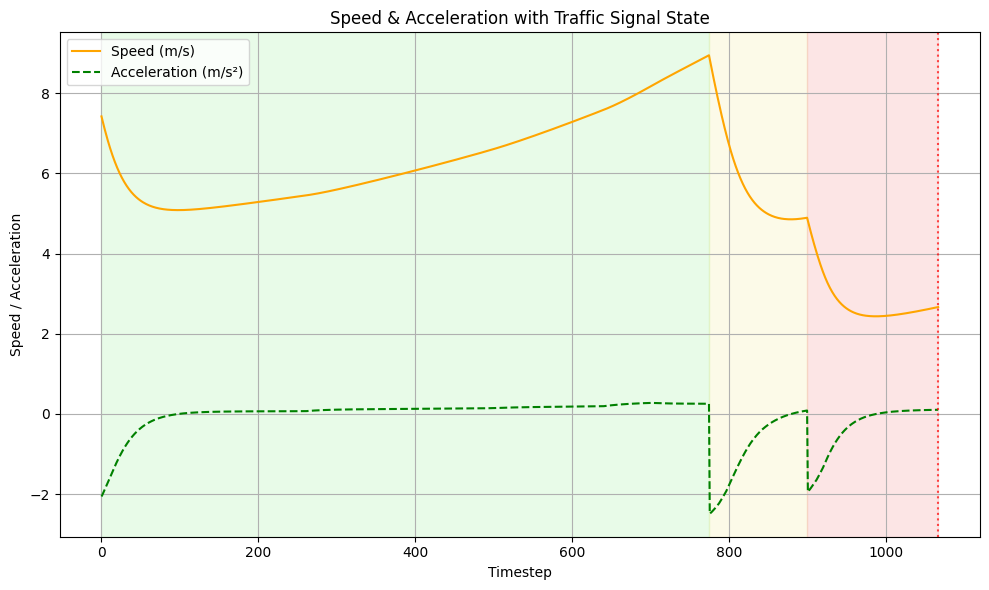

In [50]:
#load test data
#test_data_csv_path = "/content/drive/MyDrive/signal_sim_testSet128.csv"
#test_data_csv_path = "/content/drive/MyDrive/cf_sim_testSet_new1.csv"

#load the data and then reset the env with the loaded data for each episode
#test_episode_starting_data = load_training_data(test_data_csv_path)

#populate test_episode_starting_data with synthetic data
test_episode_starting_data = pd.DataFrame(columns=['FV_veh_id', 'FV_positions', 'FVSpd', 'time'])

new_row = pd.DataFrame([{
    'FV_veh_id': 1,
    'FV_positions': 225.0,
    'FVSpd': 7.5,
    'time': 75
}])

# Add the new row
test_episode_starting_data = pd.concat([test_episode_starting_data, new_row], ignore_index=True)

# Disable gradient computation
with torch.no_grad():
    for idx, row in test_episode_starting_data.iterrows():
        #collect data for plotting
        distances = []
        speeds = []
        accelerations = []
        signal_states = []  # To store signal states
        timesteps = []
        # Reset the environment with next row data from the training set
        obs = env.reset(row)
        state, achieved_goal, goal = obs["state"], obs["achieved_goal"], obs["desired_goal"]

        print(f"\n--- Episode {idx+1} start ---")
        total_reward = 0
        done = False
        step = 0

        while not done:
            #action = env.action_space.sample()[0]
            state_tensor = torch.FloatTensor(state).unsqueeze(0) # convert state to tensor
            goal_tensor = torch.FloatTensor(goal).unsqueeze(0) # convert goal to tensor
            action = actor(state_tensor, goal_tensor).detach().numpy()[0][0] # action sampling using actor network
            #action += np.random.normal(0, exploration_noise, size=action_dim) # add exploration noise
            #action = np.clip(action, -max_action, max_action)[0] # action clipping for safety
            #print state and goal tensor and action
            logger.debug(f"State: {state_tensor}, Goal: {goal_tensor}, Action: {action}")

            next_obs, reward, done, _ = env.step(action)
            next_state, next_achieved_goal, next_goal = (
                next_obs["state"], next_obs["achieved_goal"], next_obs["desired_goal"]
            )
            logger.debug(f"Step {step}: State={state}, Action={action}, Reward={reward}, Next State={next_state}, Done={done}")
            # Extract from state
            dist, speed, _ = next_state
            #save the data for plotting
            distances.append(dist)
            speeds.append(speed)
            accelerations.append(action)
            timesteps.append(step)
            signal_states.append(next_state[2])

            total_reward += reward
            state = next_state
            step += 1
        if state[2] in (0,1,2):
          logger.info(f"Episode {idx+1} ended. Total Reward: {total_reward}")

          signal_cross_index = next((i for i, d in enumerate(distances) if d >= 470), None)

          # Define signal colors
          signal_color_map = {0: 'lightcoral', 1: 'khaki', 2: 'lightgreen'}
          # Find the timestep where distance crosses 0 (traffic signal location)
          signal_cross_timestep = None
          for i, dist in enumerate(distances):
            if dist <= 0:
              signal_cross_timestep = timesteps[i]
              break

          fig, (ax2) = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
          """
          fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
          #1st plot for distance
          line1 = ax1.plot(timesteps, distances, label="Distance (m)", color="blue")
          ax1.set_ylabel("Distance (m)")
          ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label="Signal Location")
          if signal_cross_timestep is not None:
              ax1.axvline(x=signal_cross_timestep, color='red', linestyle=':', alpha=0.7, label="Signal Crossing Time")
          ax1.set_title(f"Episode {idx+1} - Distance to Signal")
          ax1.legend()
          ax1.grid(True)
          """
          #2nd plot for speed and acceleration
          line2 = ax2.plot(timesteps, speeds, label="Speed (m/s)", color="orange")
          line3 = ax2.plot(timesteps, accelerations, label="Acceleration (m/s²)", color="green", linestyle='--')
          ax2.set_ylabel("Speed / Acceleration")
          ax2.set_xlabel("Timestep")

          # Draw signal state background spans
          prev_state = signal_states[0]
          start_idx = 0
          for i in range(1, len(signal_states)):
              if signal_states[i] != prev_state or i == len(signal_states) - 1:
                  end_idx = i
                  ax2.axvspan(timesteps[start_idx], timesteps[end_idx],
                              color=signal_color_map[prev_state], alpha=0.2)
                  prev_state = signal_states[i]
                  start_idx = i

          # Add signal crossing marker
          if signal_cross_timestep is not None:
              ax2.axvline(x=signal_cross_timestep, color='red', linestyle=':', alpha=0.7)

          ax2.set_title("Speed & Acceleration with Traffic Signal State")
          ax2.legend()
          ax2.grid(True)

          plt.tight_layout()
          plt.show()


## Test the Actor network on Train dataset

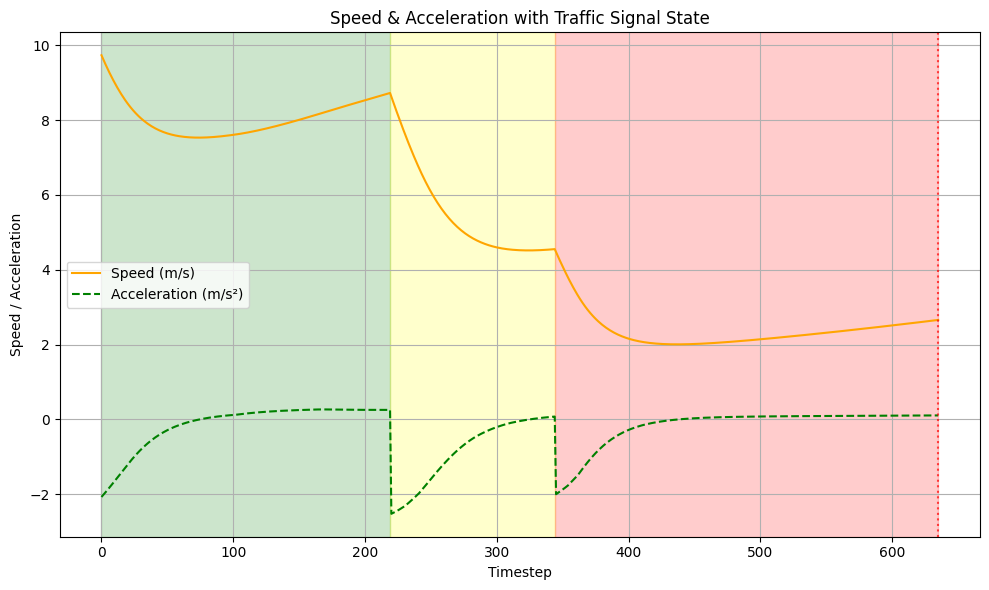

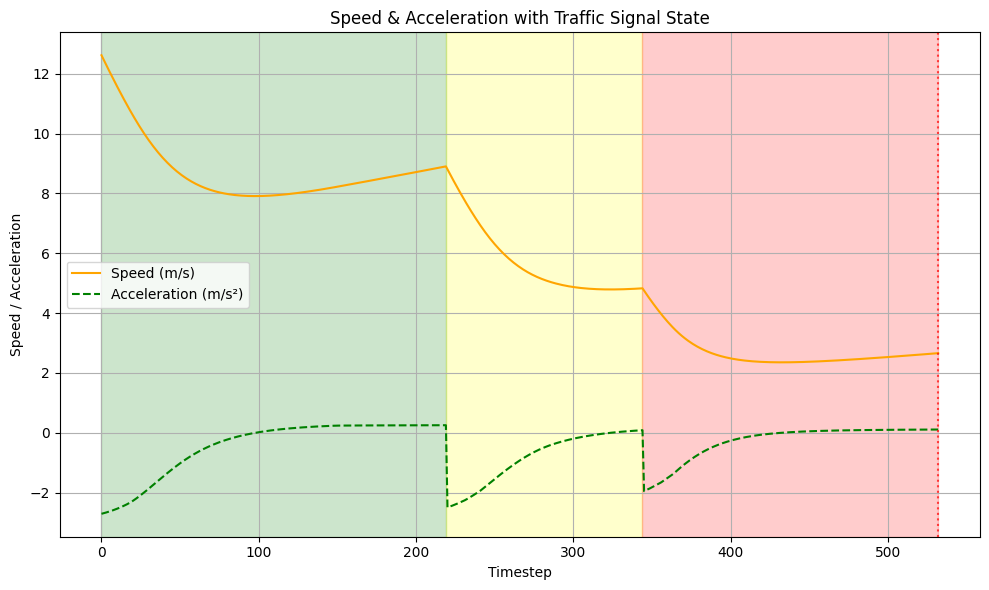

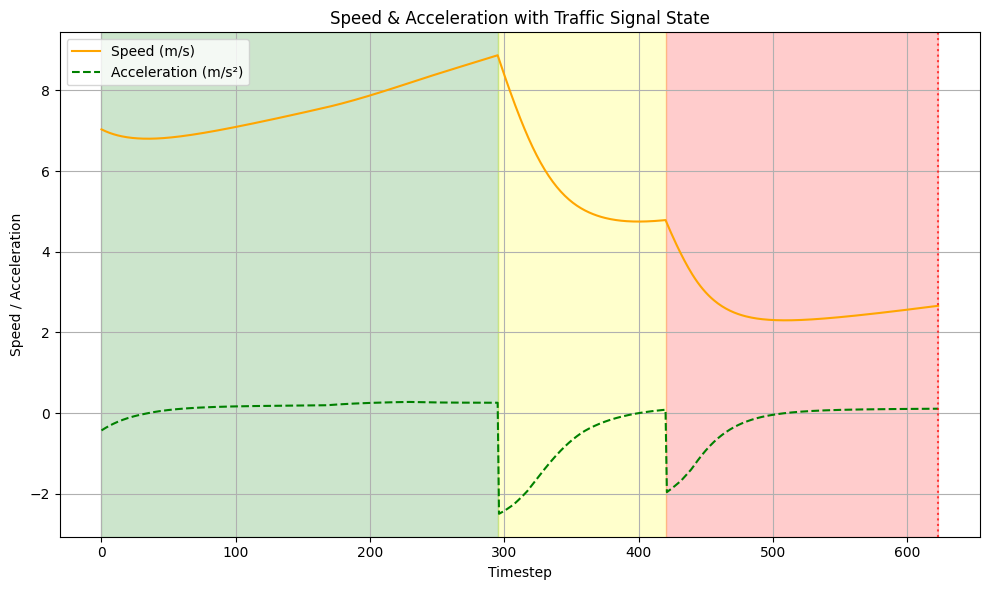

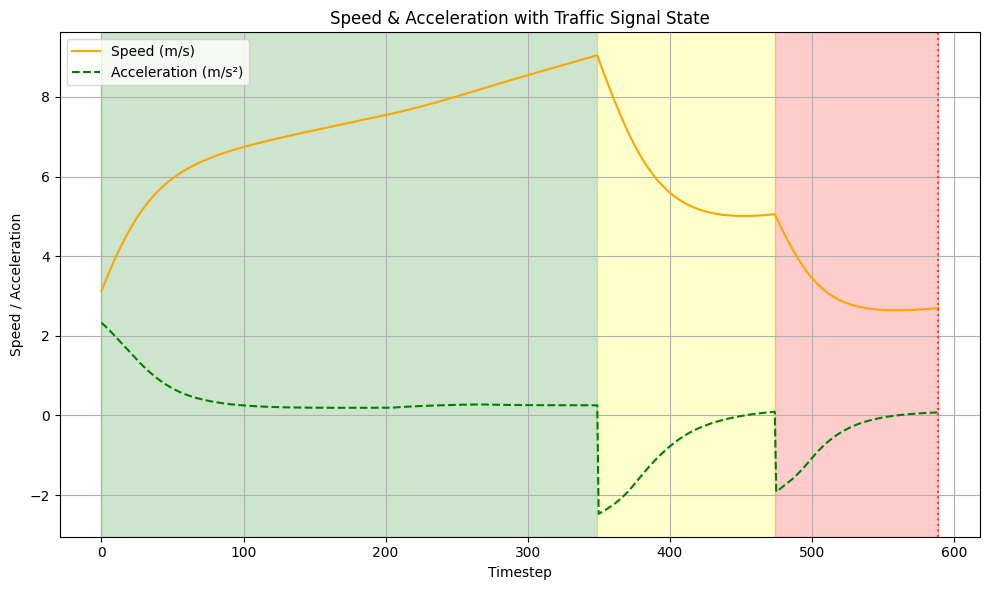

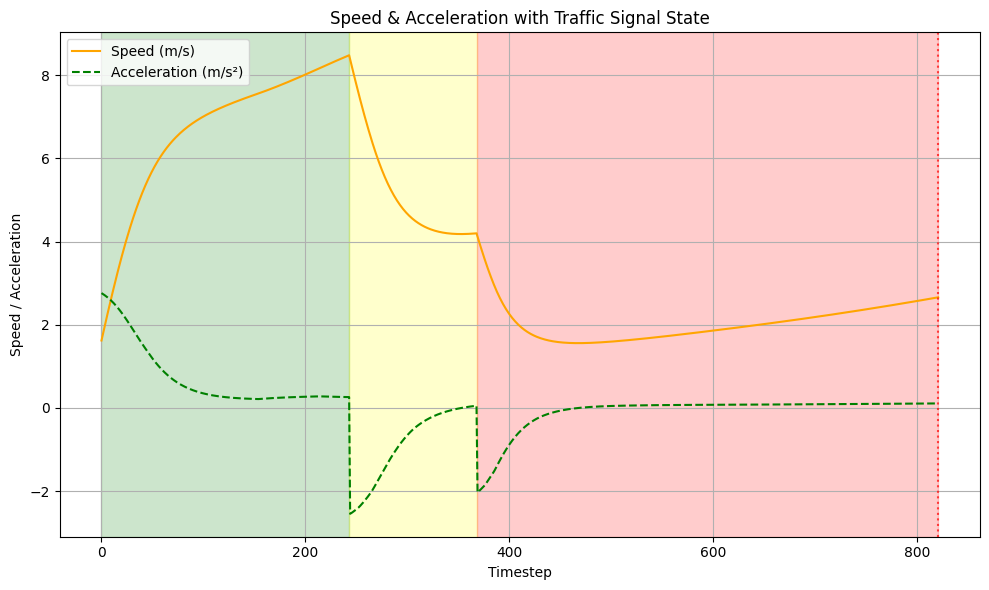

In [45]:
#load dataset
dataset_csv_path = "/content/drive/MyDrive/real_sim_trainSet_0_280_475.csv"
index = 1
#load the data and then reset the env with the loaded data for each episode
test_episode_starting_data = load_training_data(dataset_csv_path)
# Disable gradient computation
with torch.no_grad():
    for idx, row in test_episode_starting_data.iterrows():
        #collect data for plotting
        distances = []
        speeds = []
        accelerations = []
        signal_states = []  # To store signal states
        timesteps = []
        # Reset the environment with next row data from the training set
        obs = env.reset(row)
        state, achieved_goal, goal = obs["state"], obs["achieved_goal"], obs["desired_goal"]

        logger.debug(f"\n--- Episode {idx+1} start ---")
        total_reward = 0
        done = False
        step = 0

        while not done:
            #action = env.action_space.sample()[0]
            state_tensor = torch.FloatTensor(state).unsqueeze(0) # convert state to tensor
            goal_tensor = torch.FloatTensor(goal).unsqueeze(0) # convert goal to tensor
            action = actor(state_tensor, goal_tensor).detach().numpy()[0][0] # action sampling using actor network
            #action += np.random.normal(0, exploration_noise, size=action_dim) # add exploration noise
            #action = np.clip(action, -max_action, max_action)[0] # action clipping for safety
            next_obs, reward, done, _ = env.step(action)
            next_state, next_achieved_goal, next_goal = (
                next_obs["state"], next_obs["achieved_goal"], next_obs["desired_goal"]
            )
            logger.debug(f"Step {step}: State={state}, Action={action}, Reward={reward}, Next State={next_state}, Done={done}")
            # Extract from state
            dist, speed, _ = next_state
            #save the data for plotting
            distances.append(dist)
            speeds.append(speed)
            accelerations.append(action)
            timesteps.append(step)
            signal_states.append(next_state[2])

            total_reward += reward
            state = next_state
            step += 1
        if state[2] == 0:
          logger.debug(f"Episode {idx+1} ended. Total Reward: {total_reward}")

          signal_cross_index = next((i for i, d in enumerate(distances) if d >= 470), None)

          # Define signal colors
          signal_color_map = {0: 'red', 1: 'yellow', 2: 'green'}
          # Find the timestep where distance crosses 0 (traffic signal location)
          signal_cross_timestep = None
          for i, dist in enumerate(distances):
            if dist <= 0:
              signal_cross_timestep = timesteps[i]
              break

          fig, (ax2) = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
          """
          fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
          #1st plot for distance
          line1 = ax1.plot(timesteps, distances, label="Distance (m)", color="blue")
          ax1.set_ylabel("Distance (m)")
          ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label="Signal Location")
          if signal_cross_timestep is not None:
              ax1.axvline(x=signal_cross_timestep, color='red', linestyle=':', alpha=0.7, label="Signal Crossing Time")
          ax1.set_title(f"Episode {idx+1} - Distance to Signal")
          ax1.legend()
          ax1.grid(True)
          """
          #2nd plot for speed and acceleration
          line2 = ax2.plot(timesteps, speeds, label="Speed (m/s)", color="orange")
          line3 = ax2.plot(timesteps, accelerations, label="Acceleration (m/s²)", color="green", linestyle='--')
          ax2.set_ylabel("Speed / Acceleration")
          ax2.set_xlabel("Timestep")

          # Draw signal state background spans
          prev_state = signal_states[0]
          start_idx = 0
          for i in range(1, len(signal_states)):
              if signal_states[i] != prev_state or i == len(signal_states) - 1:
                  end_idx = i
                  ax2.axvspan(timesteps[start_idx], timesteps[end_idx],
                              color=signal_color_map[prev_state], alpha=0.2)
                  prev_state = signal_states[i]
                  start_idx = i

          # Add signal crossing marker
          if signal_cross_timestep is not None:
              ax2.axvline(x=signal_cross_timestep, color='red', linestyle=':', alpha=0.7)

          ax2.set_title("Speed & Acceleration with Traffic Signal State")
          ax2.legend()
          ax2.grid(True)

          plt.tight_layout()
          plt.show()
        if idx==100:
          break

In [ ]:
#check if actor is working fine

actor.eval()
with torch.no_grad():
    s = torch.randn(1, state_dim)    # or use a real obs from env: torch.FloatTensor(obs["state"]).unsqueeze(0)
    g = torch.randn(1, goal_dim)     # or real goal
    a = actor(s, g)
print("actor raw output:", a, "shape", a.shape)



actor raw output: tensor([[3.0000]]) shape torch.Size([1, 1])
